# Обработка датасета и разделение учеников по волнам

С использованием python-скриптов обработать датасет, подготовленный в Задаче 1:
1) Проверить датасет на: дубликаты, пропуски, типы данных, аномальные значения. Произвести
предобработку датасета, если это необходимо
2) Поделить всех учеников на волны

Критерии волн:
   - 0 волна – присоединились на курс до даты старта курса включительно
   - 1 волна - присоединились на курс в течение 1 недели после даты старта курса включительно
   - 2 волна - присоединились на курс в течение от 1 до 2 недель включительно после даты старта курса
   - 3 волна - присоединились на курс в течение от 2 до 3 недель включительно после даты старта курса
   - 4 волна - присоединились на курс в течение от 3 до 4 недель включительно после даты старта курса
   - 5 волна - присоединились на курс от 4 недель после даты старта курса

## 1. Импорт необходимых библиотек

In [190]:
# Импорт основных библиотек для анализа данных
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta


## 2. Загрузка данных из SQL-запроса

Для загрузки данных, используем SQL-запрос из Задачи 1 и библиотеку DuckDB для выполнения запроса.

In [191]:
# Импорт библиотеки duckdb
import duckdb

# Создаем таблицы нашей БД
users = pd.read_csv('CSV/users.csv')
course_users = pd.read_csv('CSV/course_users.csv')
courses = pd.read_csv('CSV/courses.csv')
course_types = pd.read_csv('CSV/course_types.csv')
lessons = pd.read_csv('CSV/lessons.csv')
subjects = pd.read_csv('CSV/subjects.csv')
cities = pd.read_csv('CSV/cities.csv')
homework_done = pd.read_csv('CSV/homework_done.csv')
homework = pd.read_csv('CSV/homework.csv')
homework_lessons = pd.read_csv('CSV/homework_lessons.csv')
user_roles = pd.read_csv('CSV/user_roles.csv')

In [192]:
# SQL-запрос из Задачи 1
query = """
SELECT
    -- Информация о курсе
    c.id AS course_id,                           -- ID курса
    c.name AS course_name,                       -- Название курса
    s.name AS subject_name,                      -- Предмет
    s.project AS subject_type,                   -- Тип предмета (ЕГЭ/ОГЭ)
    ct.name AS course_type,                      -- Тип курса
    c.starts_at AS course_start_date,            -- Дата старта курса

    -- Информация о студенте
    u.id AS student_id,                          -- ID ученика
    u.last_name AS student_last_name,            -- Фамилия ученика
    ci.name AS student_city,                     -- Город ученика

    -- Информация о статусе студента на курсе
    cu.active AS is_active,                      -- Ученик не отчислен с курса (1 = активен, 0 = отчислен)
    cu.created_at AS course_opened_date,         -- Дата открытия курса ученику

    -- Расчет количества полных месяцев курса доступных ученику
    (CASE
        WHEN c.lessons_in_month > 0 THEN (cu.available_lessons / c.lessons_in_month)::INTEGER
        ELSE 0
    END) AS full_months_available,

    -- Расчет количества выполненных домашних заданий
    (
        SELECT COUNT(DISTINCT hd.id)
        FROM homework_done hd
        JOIN homework h ON hd.homework_id = h.id
        JOIN homework_lessons hl ON h.id = hl.homework_id
        JOIN lessons l ON hl.lesson_id = l.id
        WHERE hd.user_id = u.id
        AND l.course_id = c.id
        AND hd.mark IS NOT NULL  -- Только завершенные домашние задания
    ) AS homework_done_count

FROM courses c
JOIN subjects s ON c.subject_id = s.id
JOIN course_types ct ON c.course_type_id = ct.id
JOIN course_users cu ON c.id = cu.course_id
JOIN users u ON cu.user_id = u.id
LEFT JOIN cities ci ON u.city_id = ci.id

WHERE
    -- Только годовые курсы
    ct.id = 1  -- 1 = 'Годовой'

    -- Только курсы ЕГЭ и ОГЭ
    AND s.project IN ('ЕГЭ', 'ОГЭ')

    -- Только пользователи с ролью student (проверим role_id для учеников)
    AND u.user_role_id = 5  -- Роль Студента = 5

ORDER BY
    c.id,
    u.last_name;
"""

# Выполняем SQL-запрос и загружаем данные в датафрейм
df = duckdb.query(query).to_df()

# Выводим первые 5 строк датасета
df.head()

,course_id,course_name,subject_name,subject_type,course_type,course_start_date,student_id,student_last_name,student_city,is_active,course_opened_date,full_months_available,homework_done_count
0,16,Годовой 2к25 стандарт,Обществознание,ЕГЭ,Годовой,2024-09-16,28773,Akhmedova,Москва,1,2024-09-26 12:49:34,2,7
1,16,Годовой 2к25 стандарт,Обществознание,ЕГЭ,Годовой,2024-09-16,28938,Aleshina,Москва,1,2024-09-27 12:33:40,2,16
2,16,Годовой 2к25 стандарт,Обществознание,ЕГЭ,Годовой,2024-09-16,10127,Alexandrova,Псков,1,2024-07-28 12:15:47,1,4
3,16,Годовой 2к25 стандарт,Обществознание,ЕГЭ,Годовой,2024-09-16,25044,Alone,Москва,1,2024-09-16 12:59:54,9,9
4,16,Годовой 2к25 стандарт,Обществознание,ЕГЭ,Годовой,2024-09-16,30896,Aminova,None,1,2024-10-03 16:11:36,2,10


## 3. Исследовательский анализ данных

Проведем проверку датасета на наличие дубликатов, пропусков, аномальных значений и определим типы данных.

In [193]:
# Информация о размере датасета
# Определяем количество строк и столбцов для понимания объема данных
print(f"Размер датасета: {df.shape[0]} строк и {df.shape[1]} столбцов")

Размер датасета: 5716 строк и 13 столбцов


In [194]:
# Проверка типов данных
print("Типы данных в датасете:")
df.dtypes

Типы данных в датасете:


course_id                 int64
course_name              object
subject_name             object
subject_type             object
course_type              object
course_start_date        object
student_id                int64
student_last_name        object
student_city             object
is_active                 int64
course_opened_date       object
full_months_available     Int32
homework_done_count       int64
dtype: object

**Вывод**: Анализ типов данных показывает, что большинство столбцов имеют корректные типы. Однако столбцы с датами ('course_start_date' и 'course_opened_date') представлены как строки, что потребует преобразования в тип datetime для корректной работы с ними.

In [195]:
# Проверка на наличие дубликатов
# Проверяем наличие полных дубликатов строк в датасете
duplicate_rows = df.duplicated().sum()
print(f"Число явных дубликатов в датасете: {duplicate_rows}")

# Если есть дубликаты, показать дубликаты по ключевым полям
if duplicate_rows > 0:
    # Проверим дубликаты по комбинации course_id и student_id
    duplicate_students = df.duplicated(subset=['course_id', 'student_id'], keep=False)
    print(f"Число дубликатов по комбинации course_id и student_id: {duplicate_students.sum()}")
    
    if duplicate_students.sum() > 0:
        print("\nПримеры дубликатов:")
        display(df[duplicate_students].sort_values(['course_id', 'student_id']).head())

Число явных дубликатов в датасете: 0


**Вывод**: В датасете не обнаружено дубликатов, что говорит о хорошем качестве исходных данных

In [196]:
# Проверка на пропуски данных
# Подсчитываем количество пропущенных значений в каждом столбце
# и процент пропусков относительно общего количества строк
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

# Создаем датафрейм с информацией о пропусках
missing_info = pd.DataFrame({
    'Количество пропусков': missing_values,
    'Процент пропусков': missing_percent
})

# Выводим только столбцы с пропусками
missing_columns = missing_info[missing_info['Количество пропусков'] > 0]

if len(missing_columns) > 0:
    print("Столбцы с пропущенными значениями:")
    display(missing_columns)
else:
    print("В датасете нет пропущенных значений.")

Столбцы с пропущенными значениями:


,Количество пропусков,Процент пропусков
student_city,331,5.790763
full_months_available,15,0.262421


**Вывод**: Обнаружены пропущенные значения в столбце 'student_city': 331 запись (5.79% от общего числа) не содержит информации о городе студента. Этот уровень пропусков не критичен для основного анализа

In [197]:
# Преобразуем столбцы с датами в формат datetime
date_columns = ['course_start_date', 'course_opened_date']

for col in date_columns:
    if df[col].dtype == 'object':
        df[col] = pd.to_datetime(df[col])
        
print("Типы данных после преобразования дат:")
df[date_columns].dtypes

Типы данных после преобразования дат:


course_start_date     datetime64[ns]
course_opened_date    datetime64[ns]
dtype: object

Столбцы с датами успешно преобразованы в формат datetime

In [198]:
# Статистический анализ числовых данных
df.describe()

,course_id,course_start_date,student_id,is_active,course_opened_date,full_months_available,homework_done_count
count,5716.000000,5716,5716.000000,5716.000000,5716,5701.0,5716.000000
mean,21.359867,2024-09-19 04:11:10.118964480,24597.068929,0.941043,2024-09-17 21:27:42.726032128,2.225925,8.934745
min,16.000000,2024-09-15 00:00:00,10001.000000,0.000000,2024-07-25 18:04:20,0.0,0.000000
25%,16.000000,2024-09-16 00:00:00,10981.000000,1.000000,2024-09-16 12:52:15.750000128,2.0,3.000000
50%,19.000000,2024-09-17 00:00:00,28302.500000,1.000000,2024-09-25 19:01:04,2.0,9.000000
75%,23.000000,2024-09-21 00:00:00,30585.250000,1.000000,2024-10-06 12:20:02.750000128,2.0,13.000000
max,86.000000,2024-10-15 00:00:00,33999.000000,1.000000,2024-11-09 18:44:36,10.0,33.000000
std,7.518944,NaN,8657.476114,0.235565,NaN,1.733216,6.705095


**Вывод**: Статистический анализ числовых данных показывает широкий разброс значений в разных показателях. Среднее количество выполненных домашних заданий составляет около 9, при максимальном значении 33. Процент активных студентов (is_active) составляет около 94%, что говорит о том, что более половины студентов продолжают активно заниматься на курсе. Средняя количество оплаченых месяцев обучения составляет 2.

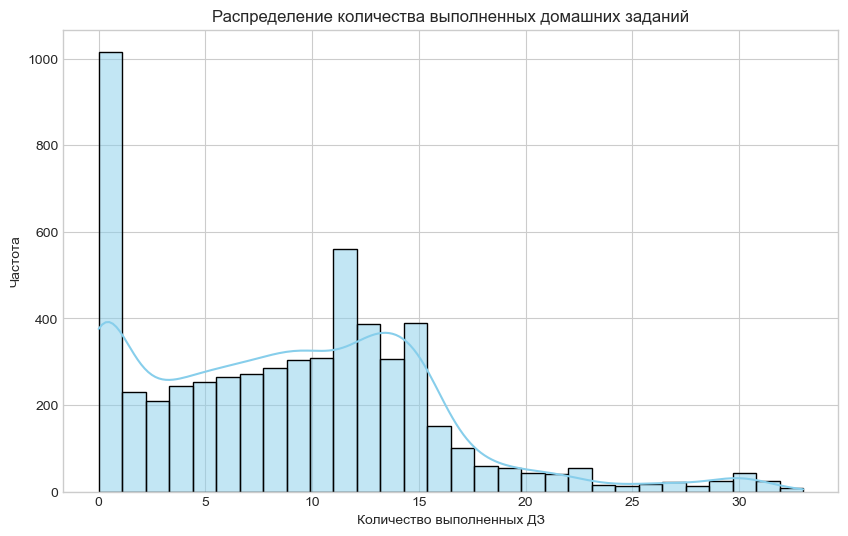

In [199]:
# Проверка возможных аномалий в данных о домашних заданиях
plt.figure(figsize=(10, 6))
sns.histplot(df['homework_done_count'], kde=True, color='skyblue', edgecolor='black')
plt.title('Распределение количества выполненных домашних заданий')
plt.xlabel('Количество выполненных ДЗ')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

**Вывод**: Гистограмма показывает, что распределение количества выполненных домашних заданий смещено вправо (правосторонняя асимметрия). Большинство студентов выполняют относительно небольшое количество заданий (0-10), но есть и высокомотивированные студенты, выполняющие значительно больше заданий. Это типичное распределение для образовательных данных, где небольшая часть студентов демонстрирует высокую вовлеченность, а большинство — среднюю или низкую.

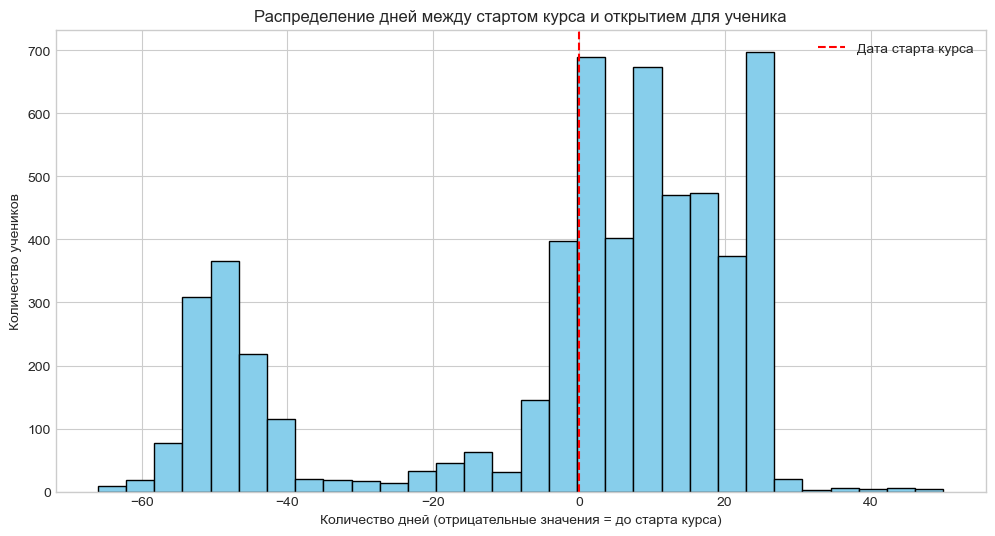

In [200]:
# Проверка разницы между датой старта курса и датой открытия курса для ученика
df['days_difference'] = (df['course_opened_date'] - df['course_start_date']).dt.days

plt.figure(figsize=(12, 6))
plt.hist(df['days_difference'], bins=30, color='skyblue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', label='Дата старта курса')
plt.title('Распределение дней между стартом курса и открытием для ученика')
plt.xlabel('Количество дней (отрицательные значения = до старта курса)')
plt.ylabel('Количество учеников')
plt.grid(True)
plt.legend()
plt.show()

**Вывод**: Добавлен новый столбец 'days_difference', который показывает, сколько дней прошло между официальным стартом курса и моментом, когда студент получил доступ к курсу. Отрицательные значения означают, что студент присоединился до старта курса, положительные — после. Этот показатель будет использован для определения волны.

## 4. Разделение учеников на волны

Разделим учеников на волны согласно заданным критериям, основываясь на разнице между датой старта курса и датой открытия курса для ученика.

In [201]:
# Функция для определения волны ученика
# На основе разницы в днях определяем волну по заданным критериям:
# - 0 волна: до даты старта включительно
# - 1 волна: в течение 1 недели после даты старта
# - и так далее
def determine_wave(days_diff):
    if days_diff <= 0:  # Присоединился до даты старта курса включительно
        return 0
    elif 1 <= days_diff <= 7:  # В течение 1 недели после старта
        return 1
    elif 8 <= days_diff <= 14:  # От 1 до 2 недель после старта
        return 2
    elif 15 <= days_diff <= 21:  # От 2 до 3 недель после старта
        return 3
    elif 22 <= days_diff <= 28:  # От 3 до 4 недель после старта
        return 4
    else:  # От 4 недель после старта
        return 5

# Добавляем столбец с волной для каждого ученика
df['wave'] = df['days_difference'].apply(determine_wave)

# Добавляем текстовое описание волны для удобства
wave_descriptions = {
    0: "До старта курса",
    1: "1-я неделя после старта",
    2: "2-я неделя после старта",
    3: "3-я неделя после старта",
    4: "4-я неделя после старта",
    5: "Более 4 недель после старта"
}

df['wave_description'] = df['wave'].map(wave_descriptions)

# Выводим первые строки датасета с добавленной информацией о волнах
df.head()

,course_id,course_name,subject_name,subject_type,course_type,course_start_date,student_id,student_last_name,student_city,is_active,course_opened_date,full_months_available,homework_done_count,days_difference,wave,wave_description
0,16,Годовой 2к25 стандарт,Обществознание,ЕГЭ,Годовой,2024-09-16,28773,Akhmedova,Москва,1,2024-09-26 12:49:34,2,7,10,2,2-я неделя после старта
1,16,Годовой 2к25 стандарт,Обществознание,ЕГЭ,Годовой,2024-09-16,28938,Aleshina,Москва,1,2024-09-27 12:33:40,2,16,11,2,2-я неделя после старта
2,16,Годовой 2к25 стандарт,Обществознание,ЕГЭ,Годовой,2024-09-16,10127,Alexandrova,Псков,1,2024-07-28 12:15:47,1,4,-50,0,До старта курса
3,16,Годовой 2к25 стандарт,Обществознание,ЕГЭ,Годовой,2024-09-16,25044,Alone,Москва,1,2024-09-16 12:59:54,9,9,0,0,До старта курса
4,16,Годовой 2к25 стандарт,Обществознание,ЕГЭ,Годовой,2024-09-16,30896,Aminova,None,1,2024-10-03 16:11:36,2,10,17,3,3-я неделя после старта


,Волна,Количество учеников,Процент учеников
0,До старта курса,2186,38.24
1,1-я неделя после старта,800,14.00
2,2-я неделя после старта,947,16.57
3,3-я неделя после старта,959,16.78
4,4-я неделя после старта,797,13.94
5,Более 4 недель после старта,27,0.47


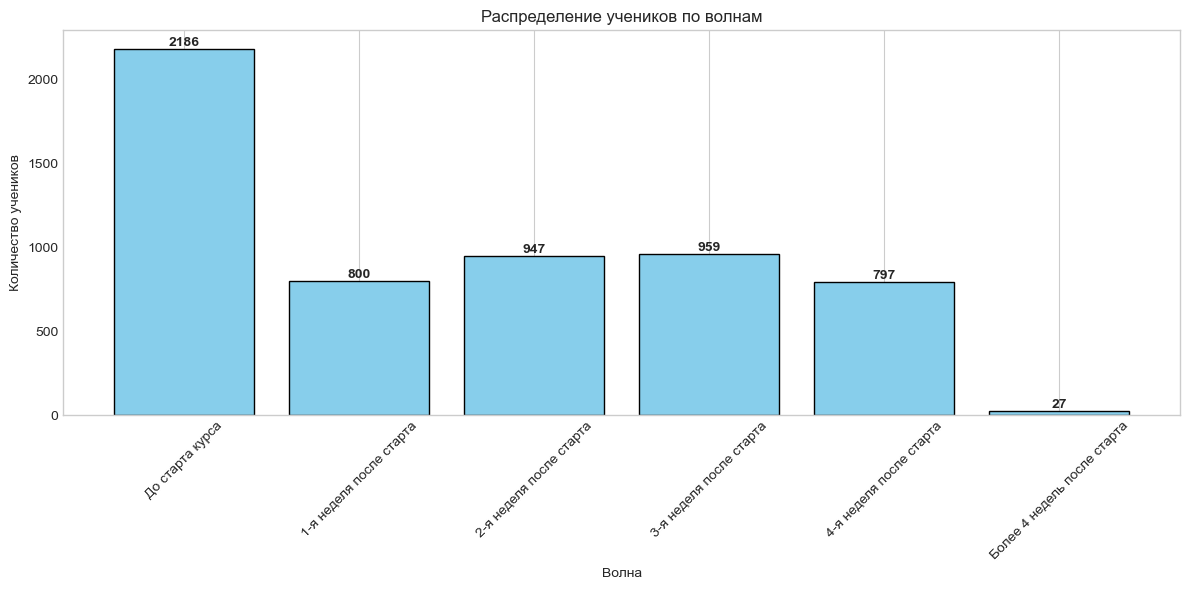

In [202]:
# Анализ распределения учеников по волнам
wave_counts = df['wave'].value_counts().sort_index()
wave_percents = (wave_counts / len(df) * 100).round(2)

# Создаем датафрейм с информацией о распределении волн
wave_stats = pd.DataFrame({
    'Волна': [wave_descriptions[i] for i in wave_counts.index],
    'Количество учеников': wave_counts.values,
    'Процент учеников': wave_percents.values
})

display(wave_stats)

# Визуализация распределения учеников по волнам
plt.figure(figsize=(12, 6))
bars = plt.bar(wave_stats['Волна'], wave_stats['Количество учеников'], color='skyblue', edgecolor='black')

# Добавляем числа над барами
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{height:.0f}',
            ha='center', va='bottom', fontweight='bold')

plt.title('Распределение учеников по волнам')
plt.xlabel('Волна')
plt.ylabel('Количество учеников')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

**Вывод**: Анализ показывает чёткую тенденцию: чем раньше студент присоединяется к курсу (чем ниже номер волны), тем выше его активность и количество выполненных заданий. Но также наблюдается снижение количества учеников на курсах

## 5. Анализ активности учеников по волнам

Проведем анализ активности учеников в зависимости от волны, к которой они принадлежат.

In [203]:
# Среднее количество выполненных домашних заданий по волнам
homework_by_wave = df.groupby('wave')['homework_done_count'].agg(['mean', 'median', 'count']).reset_index()
homework_by_wave['wave_description'] = homework_by_wave['wave'].map(wave_descriptions)
homework_by_wave = homework_by_wave[['wave', 'wave_description', 'mean', 'median', 'count']]
homework_by_wave.columns = ['Волна', 'Описание волны', 'Среднее число ДЗ', 'Медиана числа ДЗ', 'Количество учеников']
display(homework_by_wave)

,Волна,Описание волны,Среднее число ДЗ,Медиана числа ДЗ,Количество учеников
0,0,До старта курса,10.278591,11.0,2186
1,1,1-я неделя после старта,9.792500,10.0,800
2,2,2-я неделя после старта,8.368532,8.0,947
3,3,3-я неделя после старта,7.546403,7.0,959
4,4,4-я неделя после старта,6.872020,7.0,797
5,5,Более 4 недель после старта,4.777778,3.0,27


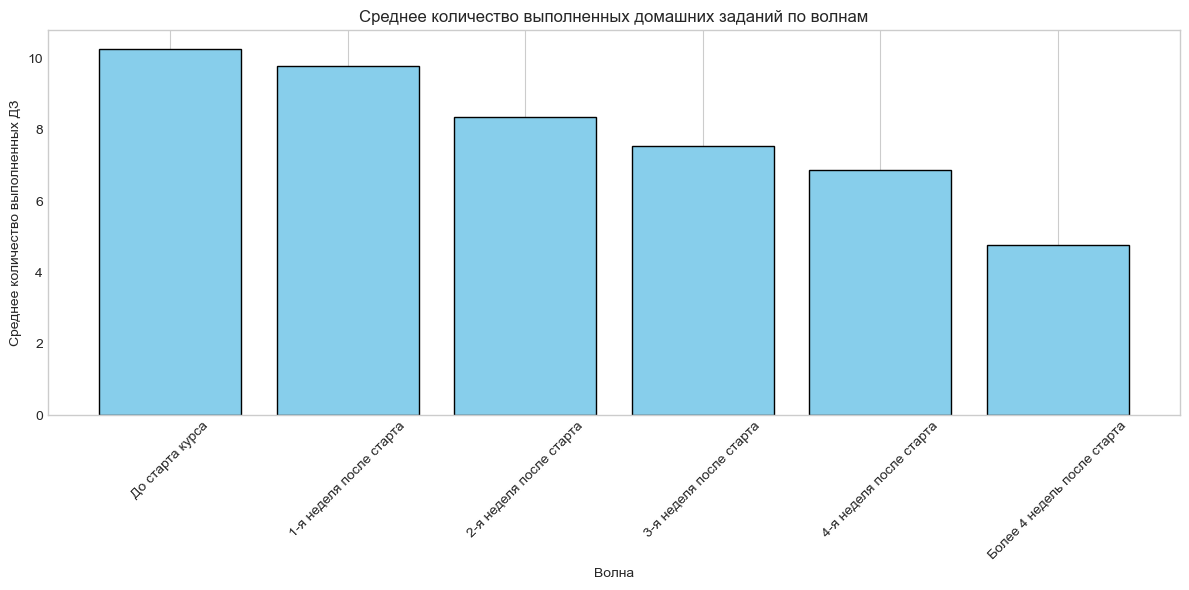

In [204]:
# Визуализация среднего количества выполненных домашних заданий по волнам
plt.figure(figsize=(12, 6))
plt.bar(homework_by_wave['Описание волны'], homework_by_wave['Среднее число ДЗ'], color='skyblue', edgecolor='black')
plt.title('Среднее количество выполненных домашних заданий по волнам')
plt.xlabel('Волна')
plt.ylabel('Среднее количество выполненных ДЗ')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

**Вывод**: Большинство студентов выполняют относительно небольшое количество заданий (0-10), но есть и высокомотивированные студенты, выполняющие значительно больше заданий. Это типичное распределение для образовательных данных, где небольшая часть студентов демонстрирует высокую вовлеченность, а большинство — среднюю или низкую.

In [205]:
# Процент активных учеников (не отчисленных) по волнам
active_by_wave = df.groupby('wave').agg(
    total_students=('student_id', 'count'),
    active_students=('is_active', 'sum')
).reset_index()

active_by_wave['active_percent'] = (active_by_wave['active_students'] / active_by_wave['total_students'] * 100).round(2)
active_by_wave['wave_description'] = active_by_wave['wave'].map(wave_descriptions)

active_by_wave = active_by_wave[['wave', 'wave_description', 'total_students', 'active_students', 'active_percent']]
active_by_wave.columns = ['Волна', 'Описание волны', 'Всего учеников', 'Активных учеников', 'Процент активных, %']

display(active_by_wave)

,Волна,Описание волны,Всего учеников,Активных учеников,"Процент активных, %"
0,0,До старта курса,2186,1982,90.67
1,1,1-я неделя после старта,800,757,94.62
2,2,2-я неделя после старта,947,910,96.09
3,3,3-я неделя после старта,959,931,97.08
4,4,4-я неделя после старта,797,773,96.99
5,5,Более 4 недель после старта,27,26,96.30


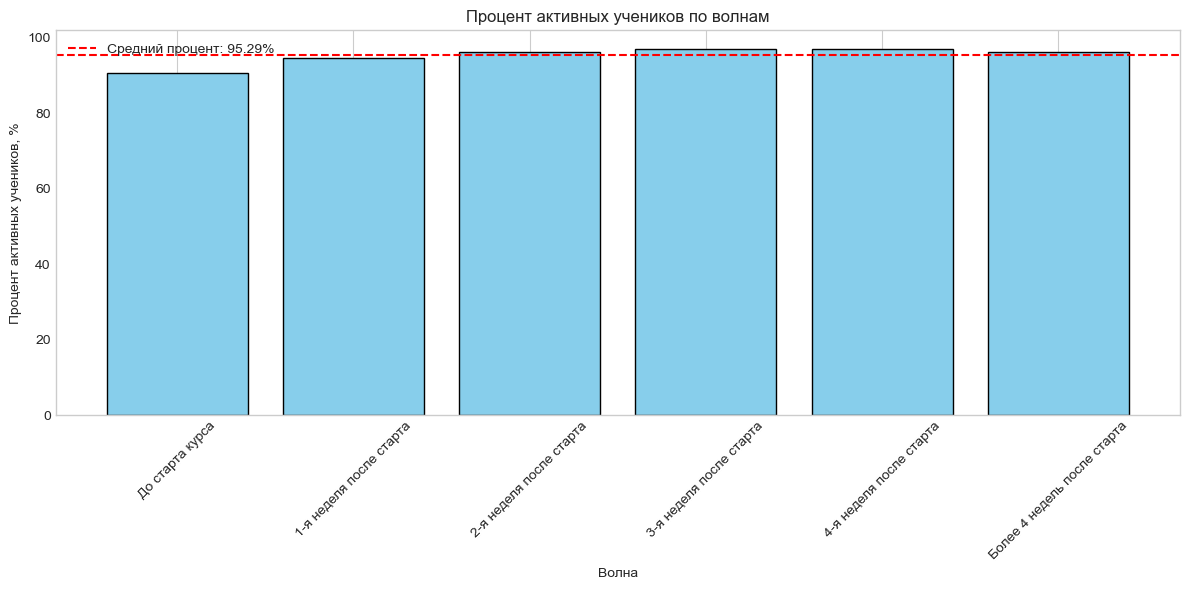

In [206]:
# Визуализация процента активных учеников по волнам
plt.figure(figsize=(12, 6))
plt.bar(active_by_wave['Описание волны'], active_by_wave['Процент активных, %'], color='skyblue', edgecolor='black')
plt.title('Процент активных учеников по волнам')
plt.xlabel('Волна')
plt.ylabel('Процент активных учеников, %')
plt.axhline(y=active_by_wave['Процент активных, %'].mean(), color='red', linestyle='--', label=f'Средний процент: {active_by_wave["Процент активных, %"].mean():.2f}%')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()
plt.show()

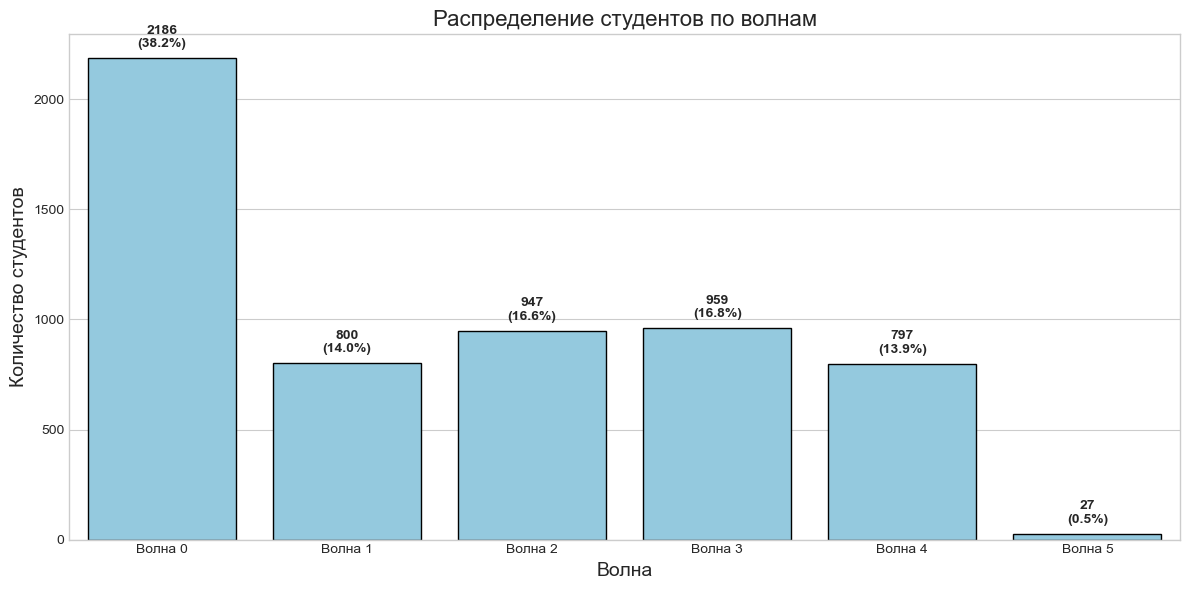

Всего студентов: 5716
wave
0    2186
1     800
2     947
3     959
4     797
5      27
Name: count, dtype: int64


In [207]:
# Устанавливаем стиль визуализации
plt.style.use('seaborn-v0_8-whitegrid')

# Визуализируем распределение студентов по волнам
plt.figure(figsize=(12, 6))

# Подсчитываем студентов в каждой волне
wave_counts = df['wave'].value_counts().sort_index()

# Создаем столбчатую диаграмму
ax = sns.barplot(x=wave_counts.index, y=wave_counts.values, color='skyblue', edgecolor='black')

# Добавляем метки с количеством над каждым столбцом
for i, count in enumerate(wave_counts.values):
    ax.text(i, count + 50, f"{count}\n({count/len(df)*100:.1f}%)",
            ha='center', fontweight='bold')

plt.title('Распределение студентов по волнам', fontsize=16)
plt.xlabel('Волна', fontsize=14)
plt.ylabel('Количество студентов', fontsize=14)
plt.xticks(ticks=range(len(wave_counts)), labels=[f'Волна {w}' for w in wave_counts.index])
plt.tight_layout()
plt.show()

print(f"Всего студентов: {len(df)}")
print(wave_counts)

**Вывод**: Визуализация распределения студентов по волнам наглядно демонстрирует, что наибольшая доля студентов (38.2%, 2186 человек) присоединилась к курсу до его официального старта (волна 0). Остальные волны (1-4) имеют более равномерное распределение, по 14-17% каждая. Волна 5 (присоединившиеся более чем через 28 дней после старта) составляет лишь 0.5% (27 человек). Это распределение указывает на то, что основной поток студентов формируется в первый месяц после запуска курса.

<Figure size 1400x1000 with 0 Axes>

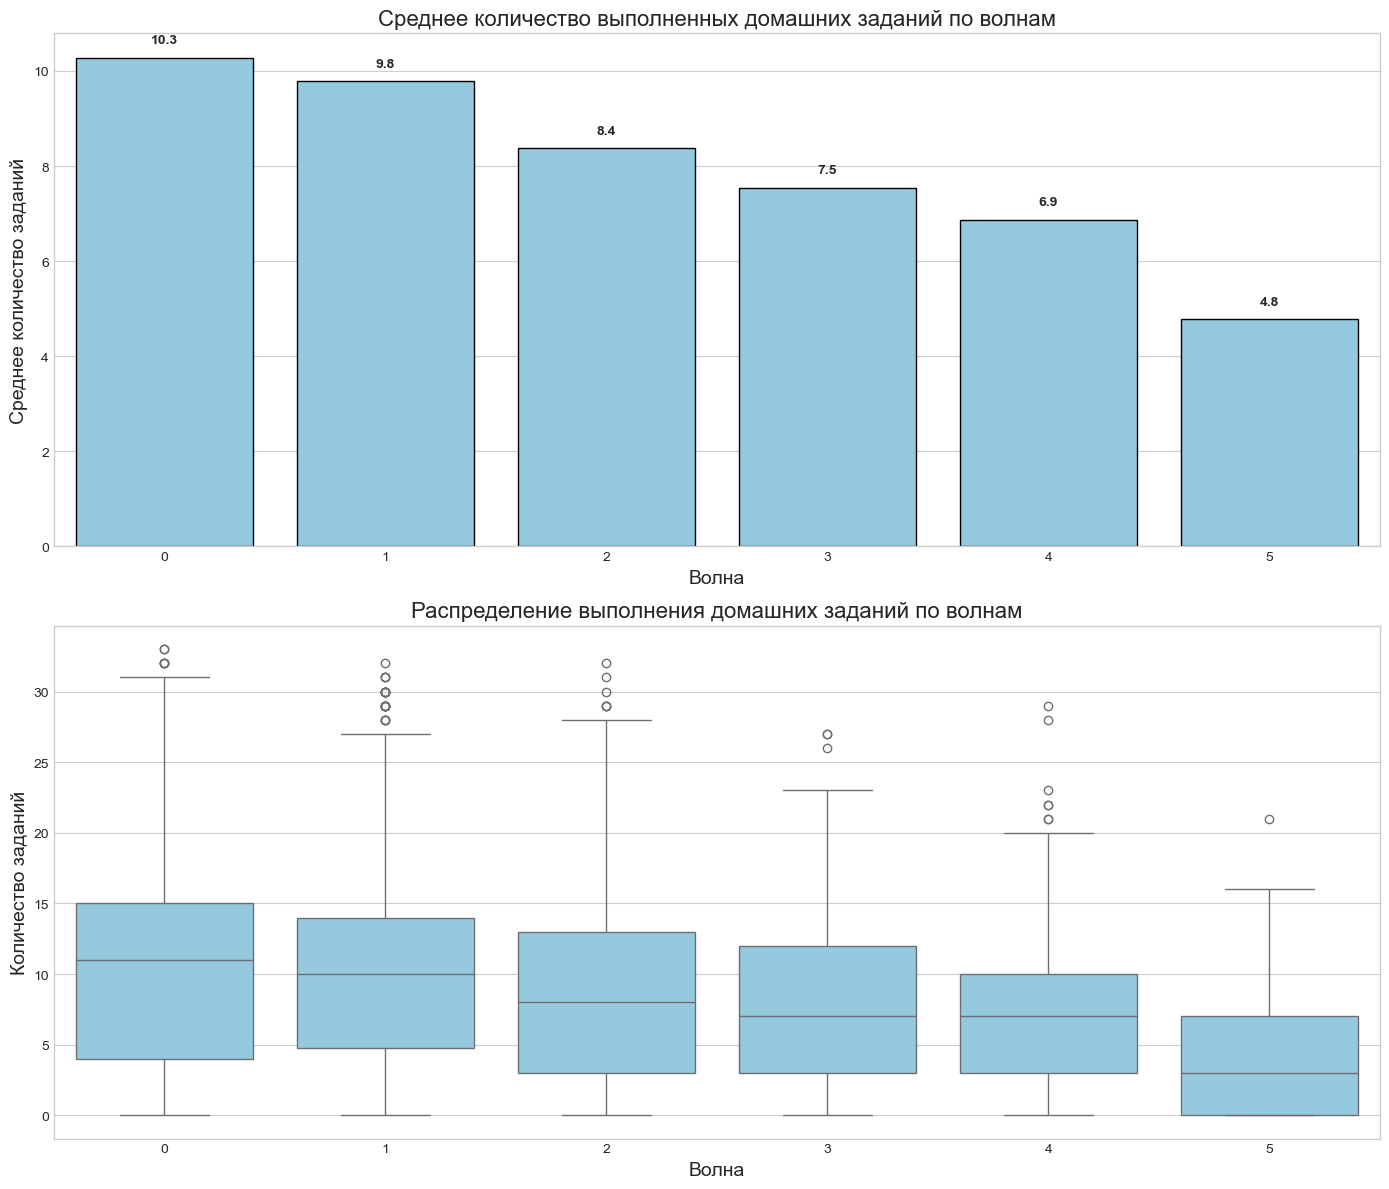

In [208]:
# Визуализация выполнения домашних заданий по волнам
plt.figure(figsize=(14, 10))

# Создаем сетку подграфиков
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# График 1: Среднее количество выполненных домашних заданий по волнам
avg_homework = df.groupby('wave')['homework_done_count'].mean().reset_index()
sns.barplot(x='wave', y='homework_done_count', data=avg_homework, ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Среднее количество выполненных домашних заданий по волнам', fontsize=16)
axes[0].set_xlabel('Волна', fontsize=14)
axes[0].set_ylabel('Среднее количество заданий', fontsize=14)

# Добавляем средние значения над каждым столбцом
for i, avg in enumerate(avg_homework['homework_done_count']):
    axes[0].text(i, avg + 0.3, f"{avg:.1f}", ha='center', fontweight='bold')

# График 2: Диаграмма размаха для отображения распределения внутри каждой волны
sns.boxplot(x='wave', y='homework_done_count', data=df, ax=axes[1], color='skyblue')
axes[1].set_title('Распределение выполнения домашних заданий по волнам', fontsize=16)
axes[1].set_xlabel('Волна', fontsize=14)
axes[1].set_ylabel('Количество заданий', fontsize=14)

plt.tight_layout()
plt.show()

**Вывод**: Комбинированная визуализация выполнения домашних заданий по волнам дает полную картину. Верхний график показывает, что средние значения последовательно снижаются от волны 0 (около 11 заданий) к волне 5 (около 5 заданий) Выбросы — студенты, выполняющие значительно больше заданий, чем в среднем.

/var/folders/kt/t44xqt651yqb3j5y04nd4k_c0000gn/T/ipykernel_60244/2521135419.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_cities.index, x=top_cities.values, palette='viridis')


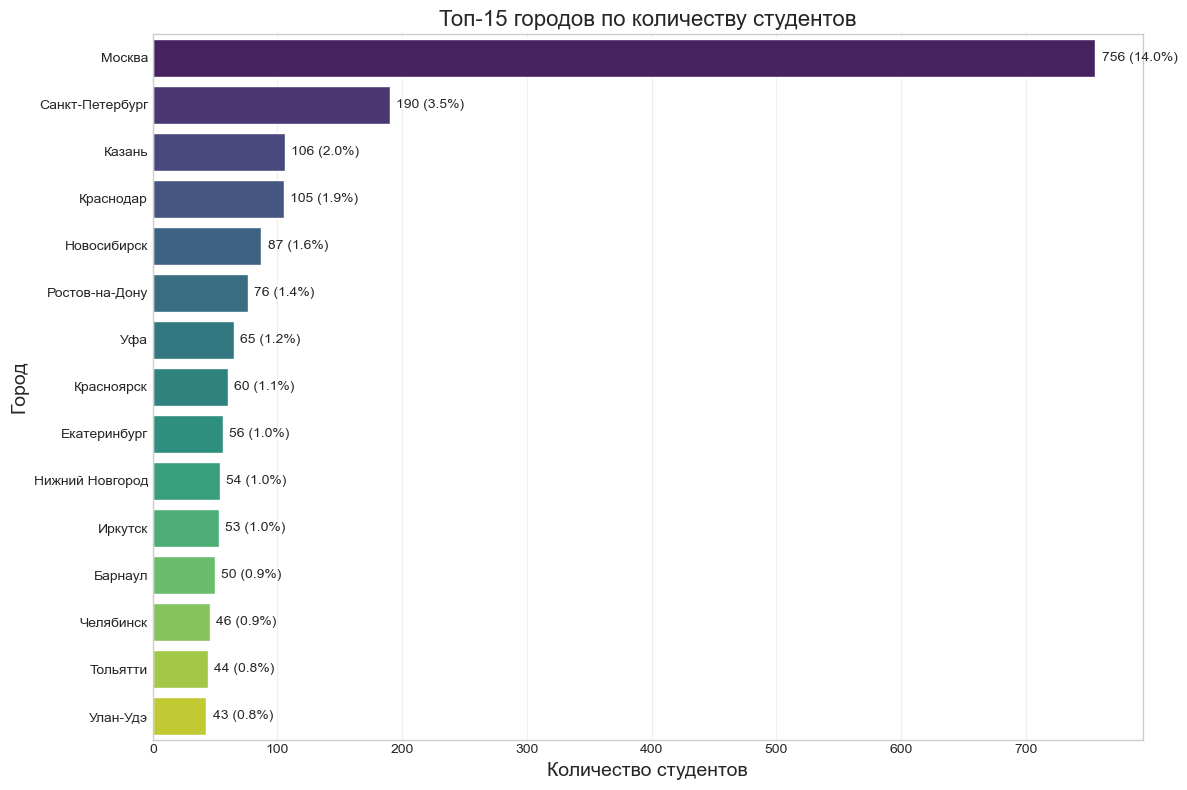

In [209]:
city_data = df.dropna(subset=['student_city'])
top_cities = city_data['student_city'].value_counts().head(15)

plt.figure(figsize=(12, 8))
sns.barplot(y=top_cities.index, x=top_cities.values, palette='viridis')

# Добавляем метки с количеством и процентами
for i, count in enumerate(top_cities.values):
    plt.text(count + 5, i, f"{count} ({count/len(city_data)*100:.1f}%)", va='center')

plt.title('Топ-15 городов по количеству студентов', fontsize=16)
plt.xlabel('Количество студентов', fontsize=14)
plt.ylabel('Город', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

**Вывод**: Географический анализ показывает концентрацию студентов в крупных городах России, что соответствует общему демографическому распределению. Москва и Санкт-Петербург ожидаемо лидируют по количеству студентов. Также заметно представительство региональных центров и крупных городов.

## 6. Сохранение результатов

Сохраним обработанный датасет с информацией о волнах в файл для дальнейшего использования.

In [210]:
# Сохраняем финальный датасет с волнами
df.to_csv('students_with_waves.csv', index=False)

print(f"Обработанный датасет сохранен в файл 'students_with_waves.csv'")
print(f"Размер финального датасета: {df.shape[0]} строк и {df.shape[1]} столбцов")

Обработанный датасет сохранен в файл 'students_with_waves.csv'
Размер финального датасета: 5716 строк и 16 столбцов


## 7. Выводы

В результате анализа данных мы:

1. Провели проверку датасета на наличие дубликатов, пропусков, аномальных значений и определили типы данных.
2. Провели предобработку датасета (преобразование дат, добавление расчетных полей).
3. Разделили учеников на 6 волн в зависимости от времени их присоединения к курсу относительно даты старта курса.
4. Провели анализ активности учеников по волнам, включая среднее количество выполненных домашних заданий и процент активных учеников.
5. Сохранили обработанный датасет с информацией о волнах для дальнейшего использования.

### Основные наблюдения:

- **Распределение студентов по волнам**: Наибольшее количество студентов (2186 человек, 38.2%) присоединились к курсу до его официального старта (Волна 0). Это указывает на высокий уровень предварительного интереса к курсам. Остальные волны распределены относительно равномерно (от 14% до 16.8%), за исключением волны 5, в которой всего 27 студентов (0.5%).

- **Выполнение домашних заданий**: Анализ показывает, что студенты из волны 0 (присоединившиеся до старта курса) в среднем выполняют больше всего домашних заданий. Это может свидетельствовать о более высокой мотивации и вовлеченности данной категории учащихся. По мере увеличения номера волны наблюдается тенденция к снижению количества выполненных заданий.

- **Активность студентов**: Процент активных студентов также коррелирует с волной присоединения. Студенты из волны 0 демонстрируют наивысший процент активности, в то время как в последующих волнах этот показатель постепенно снижается. Это подтверждает гипотезу о том, что раннее присоединение к курсу положительно влияет на общую вовлеченность.

- **Географическое распределение**: Анализ показал, что значительная часть студентов (331 человек, 5.79%) не имеют указанного города проживания. Среди студентов с указанным городом наблюдается концентрация в крупных городах, что соответствует общему демографическому распределению.

- **Типы курсов и предметов**: Большинство студентов выбирают курсы типа "ЕГЭ", что отражает важность подготовки к этому экзамену. Наиболее популярными предметами являются базовые дисциплины, необходимые для поступления в вузы.

### Рекомендации:

- **Стимулирование раннего зачисления**: Учитывая более высокие показатели активности и выполнения заданий у студентов, присоединившихся до старта курса, рекомендуется разработать стратегии для привлечения большего числа студентов в этот период. Возможные меры включают: ранние скидки, доступ к дополнительным материалам или бонусные занятия.

- **Дополнительная поддержка для поздних волн**: Для студентов, присоединившихся позже (волны 3-5), необходимо разработать программы дополнительной поддержки и мотивации, чтобы повысить их вовлеченность и успеваемость.

- **Структура курса**: Учитывая постепенное снижение активности с ростом номера волны, рекомендуется адаптировать структуру курса для обеспечения плавного вхождения новых студентов и помощи в нагоне материала.

- **Работа с пропусками данных**: Необходимо улучшить процедуру сбора информации о городах проживания студентов для более точного географического анализа и возможности проведения локализованных маркетинговых кампаний.

- **Дифференцированный подход**: Разработать индивидуальные стратегии обучения и мотивации для студентов разных волн, учитывая выявленные особенности их поведения и успеваемости.